In [15]:
import os, math, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss,
                             log_loss, roc_curve, precision_recall_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [16]:
df = pd.read_csv("Loan_Data.csv")
print(f"Loaded Loan_Data.csv with shape {df.shape}")
display(df.head())

assert "default" in df.columns, "Data must include a 'default' column (0/1)."
assert "loan_amt_outstanding" in df.columns, "Data must include 'loan_amt_outstanding' (EAD proxy)"

Loaded Loan_Data.csv with shape (10000, 8)


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


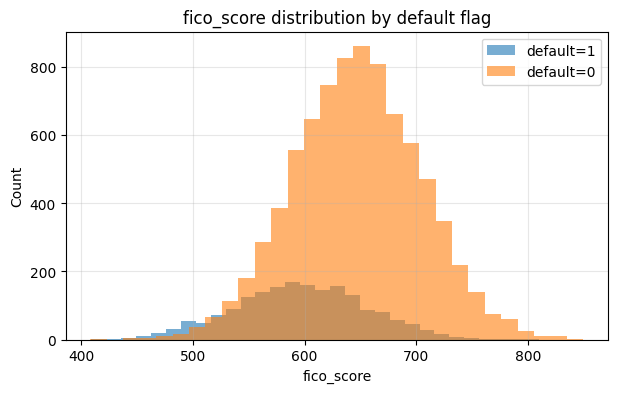

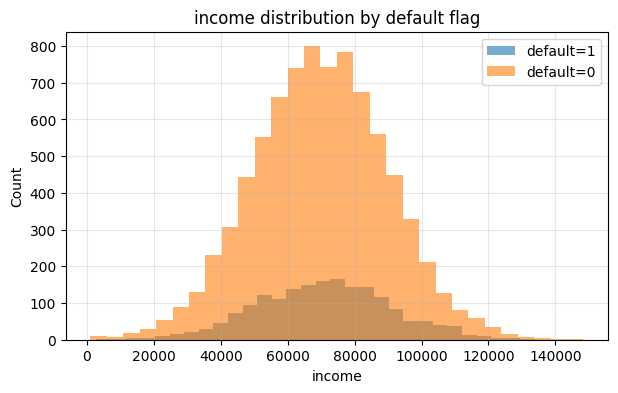

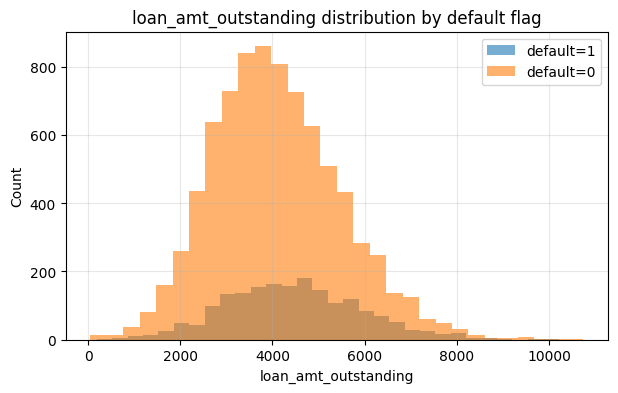

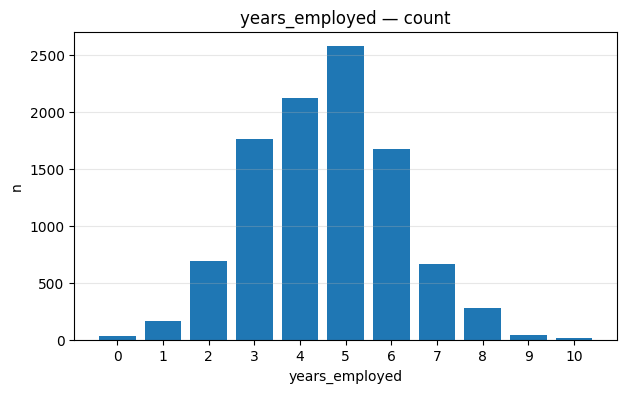

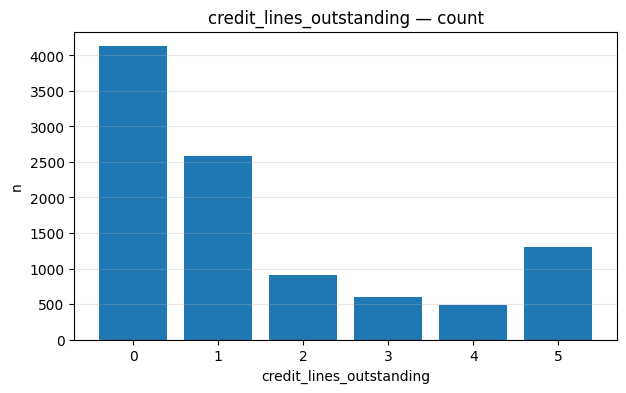

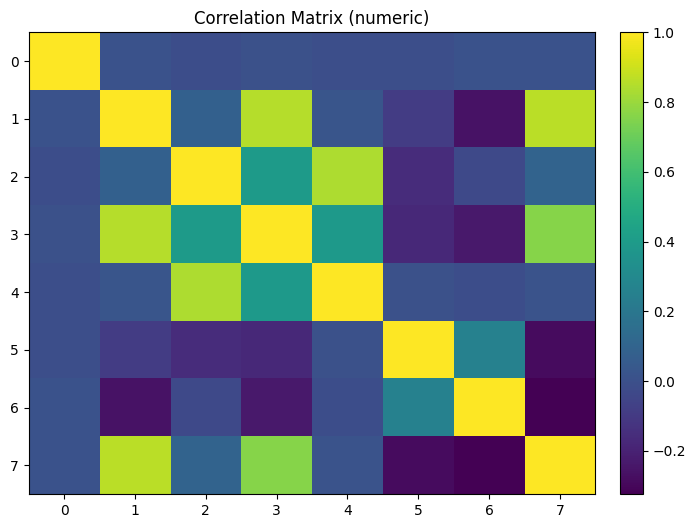

In [17]:
def dual_hist(feature, bins=30):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.hist(df.loc[df["default"]==1, feature], bins=bins, alpha=0.6, label="default=1")
    ax.hist(df.loc[df["default"]==0, feature], bins=bins, alpha=0.6, label="default=0")
    ax.set_title(f"{feature} distribution by default flag")
    ax.set_xlabel(feature); ax.set_ylabel("Count"); ax.grid(alpha=0.3); ax.legend()
    plt.show()

for col in ["fico_score", "income", "loan_amt_outstanding"]:
    if col in df.columns:
        dual_hist(col)

# bar counts for years_employed and credit_lines_outstanding
for cat in ["years_employed", "credit_lines_outstanding"]:
    if cat in df.columns:
        counts = df[cat].value_counts().sort_index()
        fig, ax = plt.subplots(figsize=(7,4))
        ax.bar(counts.index.astype(str), counts.values)
        ax.set_title(f"{cat} — count")
        ax.set_xlabel(cat); ax.set_ylabel("n"); ax.grid(axis="y", alpha=0.3)
        plt.show()

# correlation heatmap (numeric)
fig, ax = plt.subplots(figsize=(8,6))
corr = df.select_dtypes(include=[np.number]).corr()
im = ax.imshow(corr, aspect="auto")
ax.set_title("Correlation Matrix (numeric)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

In [18]:
# --- 2) Feature engineering (deterministic & simple) ------------------------
work = df.copy()

if "income" in work.columns and "total_debt_outstanding" in work.columns:
    work["ratio_income_Totdebt"] = work["income"] / work["total_debt_outstanding"].replace(0, np.nan)
if "income" in work.columns and "loan_amt_outstanding" in work.columns:
    work["ratio_income_loan_amt"] = work["income"] / work["loan_amt_outstanding"].replace(0, np.nan)

for c in ["ratio_income_Totdebt", "ratio_income_loan_amt"]:
    if c in work.columns:
        med = work[c].replace([np.inf, -np.inf], np.nan).median()
        work[c] = work[c].replace([np.inf, -np.inf], np.nan).fillna(med)

id_col = "customer_id" if "customer_id" in work.columns else None
y = work["default"].astype(int).values
X = work.drop(columns=[c for c in ["default", id_col] if c in work.columns])

num_cols = list(X.columns)  # all numeric in this dataset
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[("imp", SimpleImputer(strategy="median")),
                               ("sc", StandardScaler())]), num_cols),
    ],
    remainder="drop"
)

In [19]:
# --- 3) Train / validation split -------------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print(f"\nSplit → Train: {X_tr.shape}, Test: {X_te.shape} | "
      f"default rate (train)={y_tr.mean():.3f}, (test)={y_te.mean():.3f}")



Split → Train: (7500, 8), Test: (2500, 8) | default rate (train)=0.185, (test)=0.185


In [20]:
# --- 4) Competing models (best-of-both-worlds) ------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
candidates = []

# Logistic Regression (transparent, strong baseline)
logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])
logit_grid = {"clf__C": [0.5, 1.0, 3.0, 10.0], "clf__class_weight": [None, "balanced"]}
candidates.append(("Logistic", logit, logit_grid))

# XGBoost
xgb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", xgb.XGBClassifier(
        random_state=RANDOM_STATE, eval_metric="logloss",
        tree_method="hist", n_estimators=400,
        learning_rate=0.05, subsample=0.9, colsample_bytree=0.9
    ))
])
xgb_grid = {"clf__max_depth": [3, 4, 5], "clf__min_child_weight": [1, 5]}
candidates.append(("XGBoost", xgb_pipe, xgb_grid))

best_name, best_est, best_score = None, None, -np.inf
print("\nCross-validating models (scoring = -logloss, higher is better)...")
for name, pipe, grid in candidates:
    gs = GridSearchCV(pipe, grid, scoring="neg_log_loss", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_tr, y_tr)
    print(f"  {name:8s}  best -logloss={gs.best_score_:.5f}  params={gs.best_params_}")
    if gs.best_score_ > best_score:
        best_name, best_est, best_score = name, gs.best_estimator_, gs.best_score_

print(f"\nWinner by CV: {best_name}")



Cross-validating models (scoring = -logloss, higher is better)...
  Logistic  best -logloss=-0.00781  params={'clf__C': 10.0, 'clf__class_weight': None}
  XGBoost   best -logloss=-0.01081  params={'clf__max_depth': 3, 'clf__min_child_weight': 1}

Winner by CV: Logistic


In [21]:
# --- 5) Probability calibration --------------------------------------------
method = "isotonic" if len(X_tr) >= 5000 else "sigmoid"
calibrated = CalibratedClassifierCV(best_est, cv=5, method=method)
calibrated.fit(X_tr, y_tr)

,estimator,Pipeline(step..._iter=2000))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False



Holdout metrics →  ROC-AUC=1.0000  PR-AUC=1.0000  Brier=0.0009  LogLoss=0.0028


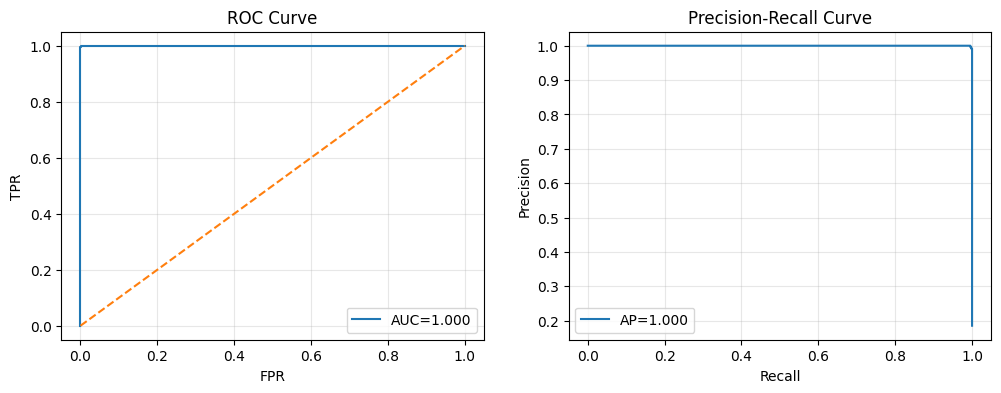

In [22]:
# --- 6) Holdout metrics + simple visuals -----------------------------------
pd_test = calibrated.predict_proba(X_te)[:, 1]
auc = roc_auc_score(y_te, pd_test)
pr_auc = average_precision_score(y_te, pd_test)
brier = brier_score_loss(y_te, pd_test)
ll = log_loss(y_te, pd_test)
print(f"\nHoldout metrics →  ROC-AUC={auc:.4f}  PR-AUC={pr_auc:.4f}  Brier={brier:.4f}  LogLoss={ll:.4f}")

def plot_roc_pr(y_true, pd_hat):
    fpr, tpr, _ = roc_curve(y_true, pd_hat)
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    # ROC
    ax[0].plot(fpr, tpr, label=f"AUC={roc_auc_score(y_true, pd_hat):.3f}")
    ax[0].plot([0,1],[0,1],"--")
    ax[0].set_title("ROC Curve"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
    ax[0].grid(alpha=0.3); ax[0].legend()
    # PR
    prec, rec, _ = precision_recall_curve(y_true, pd_hat)
    ax[1].plot(rec, prec, label=f"AP={average_precision_score(y_true, pd_hat):.3f}")
    ax[1].set_title("Precision-Recall Curve"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
    ax[1].grid(alpha=0.3); ax[1].legend()
    plt.show()

plot_roc_pr(y_te, pd_test)



Top loans by Expected Loss (test):


,PD,EAD,LGD,EL,customer_id
9944,1.0,8989.178801,0.9,8090.260921,3983392
5460,1.0,8841.923630,0.9,7957.731267,2527305
6364,1.0,8802.265206,0.9,7922.038685,2746613
346,1.0,8638.366979,0.9,7774.530281,1769864
7475,1.0,8427.592750,0.9,7584.833475,8299446
2133,1.0,8276.572480,0.9,7448.915232,6869178
7295,1.0,8133.432746,0.9,7320.089471,6982905
5201,1.0,8055.214307,0.9,7249.692876,6544829
7224,1.0,8042.192655,0.9,7237.973389,3211744
7089,1.0,7989.706883,0.9,7190.736195,8328500


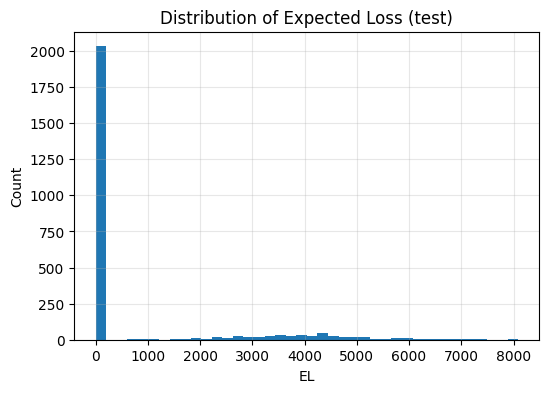

Total Expected Loss (test) = $1,849,417


In [23]:
# --- 7) Expected Loss on the test set (for a reality check) -----------------
RECOVERY = 0.10
LGD = 1.0 - RECOVERY
EAD_te = X_te["loan_amt_outstanding"].to_numpy()
EL_te = pd_test * LGD * EAD_te

test_view = X_te.copy()
test_view["PD"] = pd_test
test_view["EAD"] = EAD_te
test_view["LGD"] = LGD
test_view["EL"]  = EL_te
if id_col:
    test_view[id_col] = df.loc[X_te.index, id_col].values

print("\nTop loans by Expected Loss (test):")
display(test_view.sort_values("EL", ascending=False).head(10)[["PD","EAD","LGD","EL"] + ([id_col] if id_col else [])])

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(test_view["EL"], bins=40)
ax.set_title("Distribution of Expected Loss (test)")
ax.set_xlabel("EL"); ax.set_ylabel("Count"); ax.grid(alpha=0.3)
plt.show()

print(f"Total Expected Loss (test) = ${test_view['EL'].sum():,.0f}")

In [24]:
# --- 8) Fit FULL calibrated model for deployment ----------------------------
best_est_full = clone(best_est)
best_est_full.fit(X, y)
calibrated_full = CalibratedClassifierCV(best_est_full, cv=5, method=method)
calibrated_full.fit(X, y)


,estimator,Pipeline(step..._iter=2000))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [25]:
# --- 9) Deployment helpers: two simple entry points -------------------------
FEATURE_ORDER = list(X.columns)  # keep the exact training order

def _apply_feature_engineering(df_in: pd.DataFrame) -> pd.DataFrame:
    """Re-create ratios exactly like training; fill inf/NaN with medians."""
    df2 = df_in.copy()
    if "income" in df2.columns and "total_debt_outstanding" in df2.columns:
        df2["ratio_income_Totdebt"] = df2["income"] / df2["total_debt_outstanding"].replace(0, np.nan)
    if "income" in df2.columns and "loan_amt_outstanding" in df2.columns:
        df2["ratio_income_loan_amt"] = df2["income"] / df2["loan_amt_outstanding"].replace(0, np.nan)
    for c in ["ratio_income_Totdebt", "ratio_income_loan_amt"]:
        if c in df2.columns:
            med = df2[c].replace([np.inf, -np.inf], np.nan).median()
            df2[c] = df2[c].replace([np.inf, -np.inf], np.nan).fillna(med)
    return df2

def predict_expected_loss_df(df_in: pd.DataFrame, recovery_rate: float = 0.10) -> pd.DataFrame:
    """Batch scoring: returns original data + PD, LGD, EAD, EL."""
    df2 = _apply_feature_engineering(df_in)
    missing = [c for c in FEATURE_ORDER if c not in df2.columns]
    if missing:
        raise ValueError(f"Missing required feature columns: {missing}")
    pd_hat = calibrated_full.predict_proba(df2[FEATURE_ORDER])[:, 1]
    lgd = 1.0 - recovery_rate
    ead = df2["loan_amt_outstanding"].to_numpy()
    el = pd_hat * lgd * ead
    out = df2.copy()
    out["PD"] = pd_hat
    out["LGD"] = lgd
    out["EAD"] = ead
    out["EL"]  = el
    return out

def predict_expected_loss_row(credit_lines_outstanding: int,
                              loan_amt_outstanding: float,
                              total_debt_outstanding: float,
                              income: float,
                              years_employed: int,
                              fico_score: int,
                              recovery_rate: float = 0.10) -> dict:
    """Single borrower scoring — minimal inputs → dict with PD & EL."""
    row = pd.DataFrame([{
        "credit_lines_outstanding": credit_lines_outstanding,
        "loan_amt_outstanding": loan_amt_outstanding,
        "total_debt_outstanding": total_debt_outstanding,
        "income": income,
        "years_employed": years_employed,
        "fico_score": fico_score
    }])
    scored = predict_expected_loss_df(row, recovery_rate=recovery_rate).iloc[0]
    return {
        "PD": float(scored["PD"]),
        "LGD": float(scored["LGD"]),
        "EAD": float(scored["EAD"]),
        "EL": float(scored["EL"])
    }


In [26]:
# --- 10) Tiny demo so you see the *clear* output ----------------------------
demo = predict_expected_loss_row(
    credit_lines_outstanding=2,
    loan_amt_outstanding=5000,
    total_debt_outstanding=12000,
    income=65000,
    years_employed=4,
    fico_score=610,
    recovery_rate=0.10
)
print("\n✅ Demo (single borrower) — PD & Expected Loss")
print(json.dumps(demo, indent=2))

print("\nHow to score a whole DataFrame (same columns as training):")
display(predict_expected_loss_df(df.drop(columns=["default"])).head())



✅ Demo (single borrower) — PD & Expected Loss
{
  "PD": 0.0,
  "LGD": 0.9,
  "EAD": 5000.0,
  "EL": 0.0
}

How to score a whole DataFrame (same columns as training):


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,ratio_income_Totdebt,ratio_income_loan_amt,PD,LGD,EAD,EL
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,19.931033,14.945650,0.0,0.9,5221.545193,0.000000
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,3.238454,13.603576,1.0,0.9,1958.928726,1763.035853
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,32.481364,19.585647,0.0,0.9,3363.009259,0.000000
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,29.722181,15.599407,0.0,0.9,4766.648001,0.000000
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,13.256433,17.422978,0.0,0.9,1345.827718,0.000000


In [27]:
# Scoring helpers
def predict_expected_loss(input_df: pd.DataFrame,
                          model=calibrated_full,
                          ead_col: str = "loan_amt_outstanding",
                          recovery_rate: float = 0.10) -> pd.DataFrame:
    """
    Input: DataFrame with the same feature columns as training X (order doesn't matter).
    Output: original columns + PD + EL.
    """
    # rebuild the same feature engineering deterministically
    df2 = input_df.copy()
    if "income" in df2.columns and "total_debt_outstanding" in df2.columns:
        df2["ratio_income_Totdebt"] = df2["income"] / df2["total_debt_outstanding"].replace(0, np.nan)
    if "income" in df2.columns and "loan_amt_outstanding" in df2.columns:
        df2["ratio_income_loan_amt"] = df2["income"] / df2["loan_amt_outstanding"].replace(0, np.nan)
    for c in ["ratio_income_Totdebt", "ratio_income_loan_amt"]:
        if c in df2.columns:
            med = df2[c].replace([np.inf, -np.inf], np.nan).median()
            df2[c] = df2[c].replace([np.inf, -np.inf], np.nan).fillna(med)

    use_cols = [c for c in X.columns]  # same training columns, no ID/target
    missing = [c for c in use_cols if c not in df2.columns]
    if missing:
        raise ValueError(f"Missing required feature columns: {missing}")

    pd_hat = model.predict_proba(df2[use_cols])[:, 1]
    lgd = 1.0 - recovery_rate
    ead = df2[ead_col].to_numpy()
    el = pd_hat * lgd * ead

    out = df2.copy()
    out["PD"] = pd_hat
    out["LGD"] = lgd
    out["EAD"] = ead
    out["EL"] = el
    return out

COMPREHENSIVE LOAN PORTFOLIO ANALYSIS

Classification Results at 60% Threshold (Full Portfolio):
  Non-Default (0): 8,153 loans
  Default (1):     1,847 loans
  Default Rate:    18.5%

Top 15 Highest Risk Loans by Expected Loss:


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,Probability_to_Default,LGD,expected_loss
1997,6597386,5,10210.746690,33515.97117,107870.3896,2,649,1.0,9189.672021,9189.672021
2138,1998635,5,9563.693515,28825.60185,112120.6264,3,641,1.0,8607.324164,8607.324164
9203,4836461,5,9105.964213,42558.45149,133913.3823,3,601,1.0,8195.367792,8195.367792
9944,3983392,4,8989.178801,30103.66256,124197.6337,2,641,1.0,8090.260921,8090.260921
5460,2527305,5,8841.923630,32644.92158,115203.1519,2,541,1.0,7957.731267,7957.731267
6364,2746613,4,8802.265206,26544.26350,108128.8413,2,534,1.0,7922.038685,7922.038685
4757,1680239,5,8651.945873,30419.68257,111969.7143,3,635,1.0,7786.751286,7786.751286
346,1769864,5,8638.366979,32789.35274,111631.4497,4,627,1.0,7774.530281,7774.530281
4336,2942358,5,8593.899854,35992.98685,114836.8696,2,577,1.0,7734.509869,7734.509869
4846,3717616,5,8563.163853,26987.86727,105805.0962,5,607,1.0,7706.847468,7706.847468



Portfolio Risk Summary:
  Total Expected Loss: $7,421,182
  Average PD:          18.5%
  Median PD:           0.0%
  Max PD:              100.0%
  Loans > 60% PD:      1,847 (18.5%)
  Loans > 80% PD:      1,841 (18.4%)


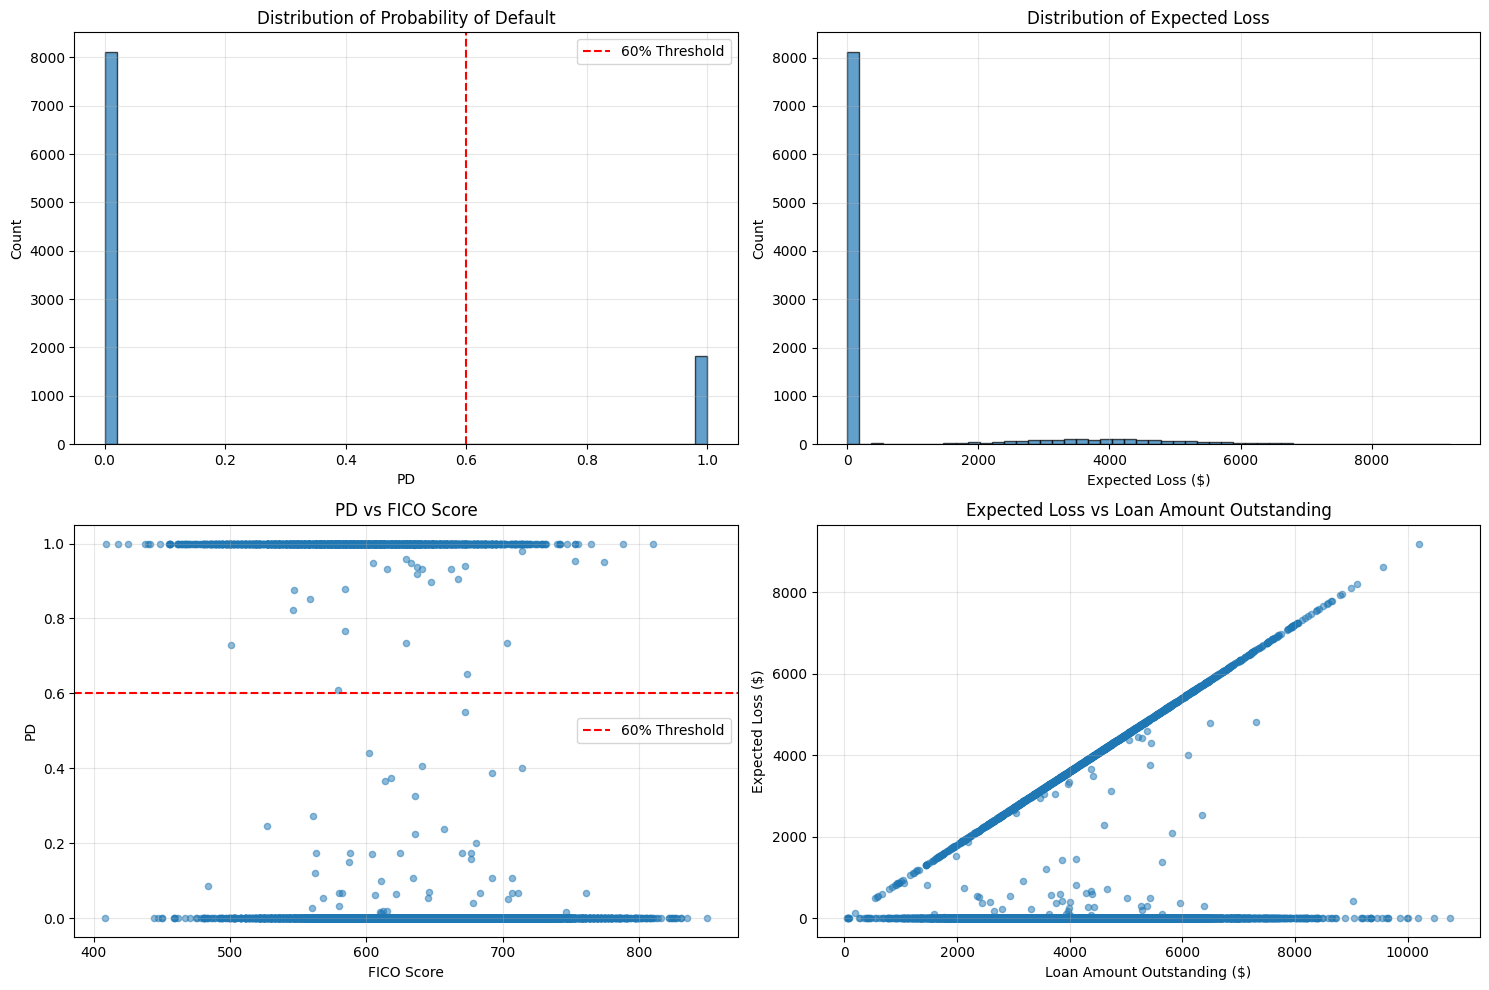


DEPLOYMENT READY: Use predict_expected_loss_row() or predict_expected_loss_df() for new scoring


In [28]:
# --- Additional Output: Full Book Analysis & 60% Threshold Reporting ---
THRESH = 0.60  # 60% threshold for classification

# Get predictions on full dataset for comprehensive analysis
full_book = df.drop(columns=["default"]).copy()
pd_full_book = calibrated_full.predict_proba(_apply_feature_engineering(full_book)[FEATURE_ORDER])[:, 1]

# Create comprehensive output similar to your style
full_book["Probability_to_Default"] = pd_full_book.round(2)
full_book["LGD"] = LGD * full_book["loan_amt_outstanding"] 
full_book["expected_loss"] = full_book["Probability_to_Default"] * full_book["LGD"]

print("=" * 60)
print("COMPREHENSIVE LOAN PORTFOLIO ANALYSIS")
print("=" * 60)

# Classification at 60% threshold on full book
predictions_60 = (pd_full_book > THRESH).astype(int)
print(f"\nClassification Results at {int(THRESH*100)}% Threshold (Full Portfolio):")
print(f"  Non-Default (0): {(predictions_60 == 0).sum():,} loans")
print(f"  Default (1):     {(predictions_60 == 1).sum():,} loans")
print(f"  Default Rate:    {predictions_60.mean():.1%}")

# Top risk loans
print(f"\nTop 15 Highest Risk Loans by Expected Loss:")
top_risk = full_book.sort_values("expected_loss", ascending=False).head(15)
display(top_risk[["customer_id", "credit_lines_outstanding", "loan_amt_outstanding", 
                  "total_debt_outstanding", "income", "years_employed", "fico_score",
                  "Probability_to_Default", "LGD", "expected_loss"]])

# Portfolio summary statistics
print(f"\nPortfolio Risk Summary:")
print(f"  Total Expected Loss: ${full_book['expected_loss'].sum():,.0f}")
print(f"  Average PD:          {pd_full_book.mean():.1%}")
print(f"  Median PD:           {np.median(pd_full_book):.1%}")
print(f"  Max PD:              {pd_full_book.max():.1%}")
print(f"  Loans > 60% PD:      {(pd_full_book > 0.60).sum():,} ({(pd_full_book > 0.60).mean():.1%})")
print(f"  Loans > 80% PD:      {(pd_full_book > 0.80).sum():,} ({(pd_full_book > 0.80).mean():.1%})")

# Risk distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# PD distribution
axes[0,0].hist(pd_full_book, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].axvline(THRESH, color='red', linestyle='--', label=f'{int(THRESH*100)}% Threshold')
axes[0,0].set_title('Distribution of Probability of Default')
axes[0,0].set_xlabel('PD'); axes[0,0].set_ylabel('Count')
axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

# Expected Loss distribution
axes[0,1].hist(full_book['expected_loss'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Distribution of Expected Loss')
axes[0,1].set_xlabel('Expected Loss ($)'); axes[0,1].set_ylabel('Count')
axes[0,1].grid(alpha=0.3)

# PD vs FICO Score
axes[1,0].scatter(full_book['fico_score'], pd_full_book, alpha=0.5, s=20)
axes[1,0].axhline(THRESH, color='red', linestyle='--', label=f'{int(THRESH*100)}% Threshold')
axes[1,0].set_title('PD vs FICO Score')
axes[1,0].set_xlabel('FICO Score'); axes[1,0].set_ylabel('PD')
axes[1,0].legend(); axes[1,0].grid(alpha=0.3)

# Expected Loss vs Loan Amount
axes[1,1].scatter(full_book['loan_amt_outstanding'], full_book['expected_loss'], alpha=0.5, s=20)
axes[1,1].set_title('Expected Loss vs Loan Amount Outstanding')
axes[1,1].set_xlabel('Loan Amount Outstanding ($)'); axes[1,1].set_ylabel('Expected Loss ($)')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("DEPLOYMENT READY: Use predict_expected_loss_row() or predict_expected_loss_df() for new scoring")
print("=" * 60)
